# Document Evaluation with modded-nanogpt

Compute per-token losses and visualize which parts of text are surprising vs predictable to the model.


In [19]:
import torch
import importlib
import inference
importlib.reload(inference)  # Reload to pick up any changes

from inference import load_checkpoint, compute_token_losses

# Load model (use 'cuda' if you have a GPU)
device = torch.device('cpu')
model = load_checkpoint('model.pt', device)
model = model.float()
model.eval()
print("Model ready!")


Loading checkpoint from model.pt...
Loaded model with 230,032,143 parameters
Model ready!


In [20]:
# ✏️ Edit this text and re-run the cell to visualize!

text = """
The quick brown fox jumps over the lazy dog. This sentence contains every letter 
of the alphabet. Machine learning models can predict common words easily, but 
struggle with unusual proper nouns like Krzyzewski or technical jargon like 
eigendecomposition.
"""

result = compute_token_losses(model, text.strip())
print(f"Total loss: {result.total_loss:.3f} nats | Perplexity: {result.perplexity:.1f}")
result.display()


Total loss: 5.452 nats | Perplexity: 233.3


In [ ]:
# Try some code
code_text = """
def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)
"""

result = compute_token_losses(model, code_text.strip())
print(f"Code - Loss: {result.total_loss:.3f} | Perplexity: {result.perplexity:.1f}")
result.display()


Code - Loss: 3.052 | Perplexity: 21.2


In [22]:
# Get detailed per-token data as a DataFrame
df = result.to_dataframe()
df.nlargest(10, 'loss')  # Most surprising tokens

,position,token_id,token,loss,prob
11,12,611,if,12.488725,0.000004
1,2,12900,fib,12.462521,0.000004
0,1,4299,def,12.370667,0.000004
24,25,1441,return,12.025085,0.000006
8,9,220,,10.530244,0.000027
31,32,12900,fib,9.181109,0.000103
4,5,7,(,7.245090,0.000714
13,14,19841,<=,6.910119,0.000998
36,37,12,-,6.695346,0.001237
39,40,1343,+,5.768746,0.003124


In [25]:
# Try some code
code_text = """
1 + 8 = 9
2 + 3 = 5
3 + 4 = 7
5 + 2 = 7
5 + 3 = 8
"""

result = compute_token_losses(model, code_text.strip())
print(f"Code - Loss: {result.total_loss:.3f} | Perplexity: {result.perplexity:.1f}")
result.display()

Code - Loss: 1.899 | Perplexity: 6.7


# Document Evaluation with modded-nanogpt

This notebook demonstrates how to:
1. Load a trained model checkpoint
2. Tokenize arbitrary documents
3. Compute per-token logits, probabilities, and losses
4. Analyze model predictions

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Import from our inference module
from inference import (
    load_checkpoint,
    encode,
    decode,
    compute_token_losses,
    TokenLossResult,
)

In [4]:
# Load model (use 'cuda' if you have a GPU)
device = torch.device('cpu')
model = load_checkpoint('model.pt', device)
model = model.float()  # Use float32 for CPU
model.eval()

print(f"Model loaded on {device}")


Loading checkpoint from model.pt...
Loaded model with 230,032,143 parameters
Model loaded on cpu


In [5]:
# Sample document
document = """The quick brown fox jumps over the lazy dog. This sentence contains every letter of the alphabet."""

# Compute losses
result = compute_token_losses(model, document)

print(f"Document: {document[:80]}...")
print(f"Number of tokens: {len(result.tokens)}")
print(f"Total loss (nats): {result.total_loss:.4f}")
print(f"Perplexity: {result.perplexity:.2f}")


Document: The quick brown fox jumps over the lazy dog. This sentence contains every letter...
Number of tokens: 20
Total loss (nats): 5.0492
Perplexity: 155.89


In [6]:
# Get DataFrame with per-token information
df = result.to_dataframe()

# Show tokens with highest loss (most surprising to the model)
print("Tokens with HIGHEST loss (most surprising):")
df.nlargest(10, 'loss')[['position', 'token', 'loss', 'prob']]


Tokens with HIGHEST loss (most surprising):


,position,token,loss,prob
11,12,sentence,10.082100,0.000042
3,4,fox,9.622682,0.000066
1,2,quick,9.368184,0.000085
7,8,lazy,9.050110,0.000117
2,3,brown,9.009238,0.000122
4,5,jumps,7.269479,0.000696
13,14,every,7.043285,0.000873
14,15,letter,5.991282,0.002500
12,13,contains,5.728718,0.003251
8,9,dog,4.779394,0.008401


In [7]:
# Show tokens with lowest loss (most predictable)
print("Tokens with LOWEST loss (most predictable):")
df.nsmallest(10, 'loss')[['position', 'token', 'loss', 'prob']]


Tokens with LOWEST loss (most predictable):


,position,token,loss,prob
16,17,the,0.441372,0.643154
18,19,.,0.859668,0.423302
6,7,the,1.158378,0.313995
15,16,of,1.457431,0.232834
9,10,.,1.590147,0.203896
17,18,alphabet,2.520545,0.080416
0,1,The,2.804925,0.060511
5,6,over,3.063115,0.046742
10,11,This,4.093828,0.016675
8,9,dog,4.779394,0.008401


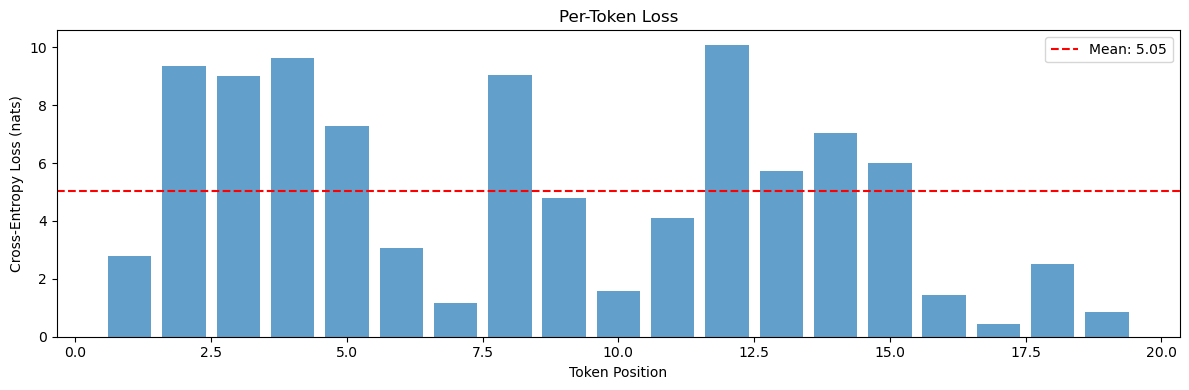

In [8]:
# Plot loss by position
plt.figure(figsize=(12, 4))
plt.bar(df['position'], df['loss'], alpha=0.7)
plt.xlabel('Token Position')
plt.ylabel('Cross-Entropy Loss (nats)')
plt.title('Per-Token Loss')
plt.axhline(y=result.total_loss, color='r', linestyle='--', label=f'Mean: {result.total_loss:.2f}')
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
## 4. Inspect Model Predictions

def show_predictions(result: TokenLossResult, position: int, top_k: int = 10):
    """Show top-k predictions at a given position."""
    probs = result.probs[position]
    top_probs, top_ids = torch.topk(probs, top_k)
    
    actual_token = result.tokens[position + 1]
    actual_str = result.token_strings[position + 1]
    
    print(f"Position {position}: After '{result.token_strings[position]}'")
    print(f"Actual next token: '{actual_str}' (prob: {probs[actual_token]:.4f})")
    print(f"\nTop {top_k} predictions:")
    for i, (p, tid) in enumerate(zip(top_probs, top_ids)):
        marker = " <-- ACTUAL" if tid == actual_token else ""
        print(f"  {i+1}. '{decode([tid.item()], skip_bos=False)}' (prob: {p:.4f}){marker}")

# Show predictions for the token with highest loss
worst_idx = df['loss'].idxmax()
show_predictions(result, worst_idx)


Position 11: After ' This'
Actual next token: ' sentence' (prob: 0.0000)

Top 10 predictions:
  1. ' is' (prob: 0.2500)
  2. ' dog' (prob: 0.0706)
  3. ' fox' (prob: 0.0497)
  4. ' time' (prob: 0.0324)
  5. ' was' (prob: 0.0239)
  6. ' cute' (prob: 0.0168)
  7. ' little' (prob: 0.0153)
  8. ' brown' (prob: 0.0141)
  9. ' one' (prob: 0.0115)
  10. ' quick' (prob: 0.0104)


In [10]:
## 5. Compare Multiple Documents

documents = {
    "Simple English": "The cat sat on the mat. It was a sunny day.",
    "Technical": "The gradient descent algorithm minimizes the loss function by iteratively updating parameters.",
    "Nonsense": "Flurble grix zonk the wibbling framistan quietly.",
    "Repetitive": "The the the the the the the the the the.",
}

results_list = []
for name, doc in documents.items():
    r = compute_token_losses(model, doc)
    results_list.append({
        'Document': name,
        'Text': doc[:40] + '...' if len(doc) > 40 else doc,
        'Tokens': len(r.tokens),
        'Loss': round(r.total_loss, 3),
        'Perplexity': round(r.perplexity, 1),
    })

pd.DataFrame(results_list)


,Document,Text,Tokens,Loss,Perplexity
0,Simple English,The cat sat on the mat. It was a sunny d...,14,3.418,30.5
1,Technical,The gradient descent algorithm minimizes...,16,5.249,190.5
2,Nonsense,Flurble grix zonk the wibbling framistan...,17,7.743,2304.8
3,Repetitive,The the the the the the the the the the.,12,2.637,14.0


In [11]:
## 6. Manual Step-by-Step (for custom analysis)

import torch.nn.functional as F

# Tokenize manually
text = "Hello, world!"
tokens = encode(text, add_bos=True)  # Important: include BOS!
print(f"Tokens: {tokens}")
print(f"Decoded: {[decode([t], skip_bos=False) for t in tokens]}")

# Get logits
input_ids = torch.tensor([tokens], dtype=torch.long, device=device)
with torch.no_grad():
    logits = model(input_ids)[0]  # Shape: (seq_len, vocab_size)

print(f"\nLogits shape: {logits.shape}")

# Get probabilities  
probs = F.softmax(logits, dim=-1)

# Compute loss for each token (except BOS)
print("\nPer-token losses:")
for i in range(len(tokens) - 1):
    target_token = tokens[i + 1]
    loss = -torch.log(probs[i, target_token]).item()
    prob = probs[i, target_token].item()
    ctx = decode([tokens[i]], skip_bos=False)
    tgt = decode([target_token], skip_bos=False)
    print(f"  After '{ctx}' -> '{tgt}': loss={loss:.3f}, prob={prob:.4f}")


Tokens: [50256, 15496, 11, 995, 0]
Decoded: ['<|endoftext|>', 'Hello', ',', ' world', '!']

Logits shape: torch.Size([5, 50304])

Per-token losses:
  After '<|endoftext|>' -> 'Hello': loss=6.369, prob=0.0017
  After 'Hello' -> ',': loss=1.494, prob=0.2244
  After ',' -> ' world': loss=5.956, prob=0.0026
  After ' world' -> '!': loss=1.170, prob=0.3105
